## Anomaly Detection - Project

### Authors: Norbert Klockiewicz, Kacper Majchrzak, Patryk Kożuch

#### Based on: <a href="https://arxiv.org/pdf/1802.04431.pdf">Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding</a>


Imports


In [52]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools as mit
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Dense, Activation, Dropout, LSTM

print(np.__version__)

1.26.4


### Class channel - load and prepare data to train model


In [53]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

### Class Model - create and train recurrent neural network


In [54]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


### Class Plotter - visualize input data, predictions and errors


In [55]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            if max(rect[0], start) <  min(rect[1], end):
                plt.axvspan(max(rect[0], start), min(rect[1], end), alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(error))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

    def plot_detected_anomalies(self, d_anomalies, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        for rect in d_anomalies:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

### Calculate error between real and predicted data, create smoothed error


In [56]:
class ErrorWindow:
    def __init__(self, channel, e_s, window_size, window_number):
        self.channel = channel
        self.e_s = e_s
        self.window_num = window_number
        self.window_size = window_size
        self.E_seq = []
        
        self.mean = np.mean(self.e_s)
        self.std = np.std(self.e_s)
        self.epsilon = self.mean + 12 * self.std
        self.indices_anomalies = np.array([])
        self.anom_scores = []
        self.non_anom_max = float('-inf')

    def find_anomalies(self):
        max_score = float('-inf')

        for z in np.arange(2, 10, 0.5):
            epsilon = self.mean + (self.std * z)
            below_epsilon = self.e_s[self.e_s < epsilon]

            delta_mean = self.mean - np.mean(below_epsilon)
            delta_std = self.std - np.std(below_epsilon)
            e_a = self.e_s[self.e_s >= epsilon]

            if len(e_a) > 0:
                anom = np.argwhere(self.e_s >= epsilon).reshape(-1)
                E_seq =[list(g) for g in mit.consecutive_groups(anom)]
                E_seq_len = len(E_seq)
                
                score = ((delta_mean/self.mean) + (delta_std/self.std)) / (E_seq_len**2 + len(e_a))
                if score > max_score:
                    max_score = score
                    self.epsilon = epsilon
                    self.E_seq = E_seq
                    self.indices_anomalies = anom
                    self.non_anom_max = max(below_epsilon)
                    
        return self.epsilon
    
    def prune_anomalies(self):
        if len(self.E_seq) == 0:
            return
        
        non_anom_max = self.non_anom_max
        
        E_seq_max = []
        for e_seq in self.E_seq:
            E_seq_max.append(max(self.e_s[e_seq[0]: e_seq[-1] + 1]))

        E_seq_max_sorted = np.sort(E_seq_max)[::-1]
        E_seq_max_sorted = np.append(E_seq_max_sorted, non_anom_max)

        i_to_remove = np.array([], dtype=int)

        for i in range(len(E_seq_max_sorted)-1):
            if (E_seq_max_sorted[i] - E_seq_max_sorted[i + 1]) / E_seq_max_sorted[i] < 0.09:
                i_to_remove = np.append(i_to_remove, np.argwhere(E_seq_max == E_seq_max_sorted[i]))
            else:
                i_to_remove = np.array([], dtype=int)
        
        i_to_remove[::-1].sort()

        if len(i_to_remove) > 0:
            e_sequences = []
            for i in range(len(self.E_seq)):
                if i not in i_to_remove:
                    e_sequences.append(self.E_seq[i])
            
            self.E_seq = e_sequences
        
        if len(self.E_seq) == 0:
            self.indices_anomalies = np.array([])
            return
        
        indices_to_keep = np.concatenate([range(e_seq[0], e_seq[-1] + 1) for e_seq in self.E_seq])

        mask = np.isin(self.indices_anomalies, indices_to_keep)
        self.indices_anomalies = self.indices_anomalies[mask]
        

    def score_anomalies(self, prior_idx):

        groups = [list(group) for group in mit.consecutive_groups(self.indices_anomalies)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean + self.std) for i in
                         range(e_seq[0], e_seq[-1] + 1)])

            score_dict['score'] = score
            self.anom_scores.append(score_dict)

In [57]:
class Errors:
    def __init__(self, channel):
        self.channel = channel
        self.error = [abs(y_h-y_t[0]) for y_h, y_t in
                  zip(channel.y_hat, channel.y_test)]
        self.normalized = np.mean(self.error / np.ptp(channel.y_test))
        self.e_s = pd.DataFrame(self.error).ewm(span=105).mean().values.flatten()

        self.window_size = 30
        self.batch_size = 70

        self.n_windows = int((channel.y_test.shape[0] - (self.batch_size * self.window_size)) / self.batch_size)
        self.i_anom = np.array([])
        self.anom_scores = []
        self.E_seq = []
        self.epsilons = []


    def detect_anomalies(self):

        for i in range(self.n_windows + 1):
            prior_idx = i * self.batch_size
            idx = self.window_size * self.batch_size + prior_idx
            window = ErrorWindow(self.channel, self.e_s[prior_idx:idx], self.window_size, i)
            
            self.epsilons.append(window.find_anomalies())
            window.prune_anomalies()
            window.score_anomalies(prior_idx)

            self.i_anom = np.append(self.i_anom, window.indices_anomalies + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores


        if len(self.anom_scores) > 0:
            self.anom_scores = sorted(self.anom_scores, key=lambda x: x['score'], reverse=True)
            self.check_scores()

    def check_scores(self):
        self.anom_scores = sorted(self.anom_scores, key=lambda x: x['start_idx'])
        for i in range(len(self.anom_scores)):
            if self.anom_scores[i]['score'] > 0.1:
                self.E_seq.append([self.anom_scores[i]['start_idx'], self.anom_scores[i]['end_idx']])

        E_seq = [self.E_seq[0]]
        for s, e in self.E_seq[1:]:
            if max(s, E_seq[-1][0]) <= min(e, E_seq[-1][1]) or s == E_seq[-1][1] + 1:
                E_seq[-1] = [min(s, E_seq[-1][0]), max(e, E_seq[-1][1])]
            else:
                E_seq.append([s, e])
        self.E_seq = E_seq
        # shift data to match the original data
        self.E_seq = [(e_seq[0] + 250,
                           e_seq[1] + 250) for e_seq in self.E_seq]

A-8
Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.8425 - val_loss: 0.2661
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.2329 - val_loss: 0.1010
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.1411 - val_loss: 0.1157
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.1207 - val_loss: 0.0920
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.1291 - val_loss: 0.0858
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.1027 - val_loss: 0.0828
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0785 - val_loss: 0.0773
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0860 - val_loss: 0.0786
Epoch 9/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0814 - val_loss: 0.0723
Epoch 10/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0718 - val_loss: 0.0714
Epoch 11/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0783 - val_loss: 0.0638
Epoch 12/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0604 - va

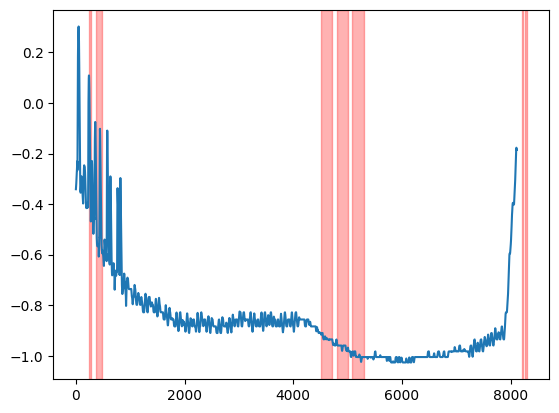

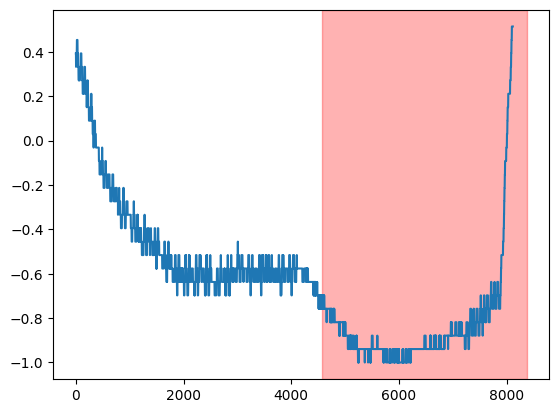

D-3
Epoch 1/35


c:\Users\Norbert\anaconda3\envs\tensorflow-cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.4252 - val_loss: 0.0053
Epoch 2/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0479 - val_loss: 4.1476e-04
Epoch 3/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0350 - val_loss: 3.1854e-04
Epoch 4/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.0294 - val_loss: 7.7003e-04
Epoch 5/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.0248 - val_loss: 4.2004e-04
Epoch 6/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0222 - val_loss: 9.5369e-04
Epoch 7/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0210 - val_loss: 4.3690e-04
Epoch 8/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0179 - val_loss: 7.5532e-04
Epoch 9/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0166 - val_loss: 4.2244e-04
Epoch 10/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0151 - val_loss: 1.0573e-04
Epoch 11/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0143 - val_loss: 0.0012
Epoch 12/35
33/33 ━━━━━━━━━

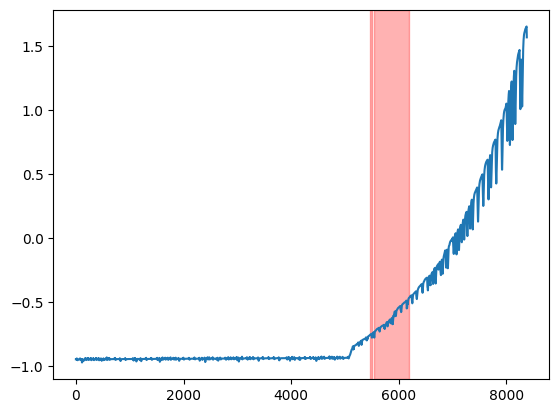

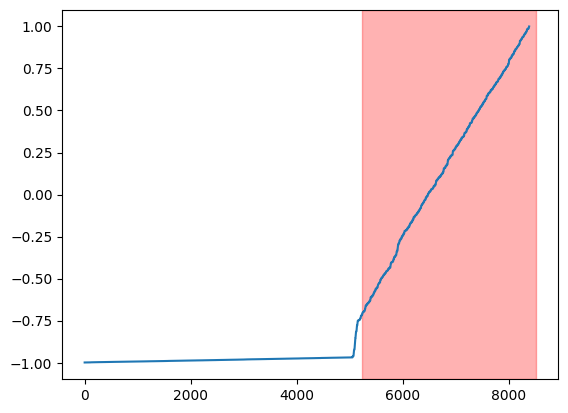

D-9
Epoch 1/35


c:\Users\Norbert\anaconda3\envs\tensorflow-cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.5933 - val_loss: 0.0030
Epoch 2/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0532 - val_loss: 0.0046
Epoch 3/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0406 - val_loss: 8.1104e-04
Epoch 4/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0331 - val_loss: 0.0013
Epoch 5/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0278 - val_loss: 0.0024
Epoch 6/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0255 - val_loss: 6.3255e-05
Epoch 7/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0226 - val_loss: 2.1862e-04
Epoch 8/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0210 - val_loss: 0.0022
Epoch 9/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0188 - val_loss: 8.0694e-05
Epoch 10/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0170 - val_loss: 4.1278e-05
Epoch 11/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0174 - val_loss: 4.7434e-04
Epoch 12/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 

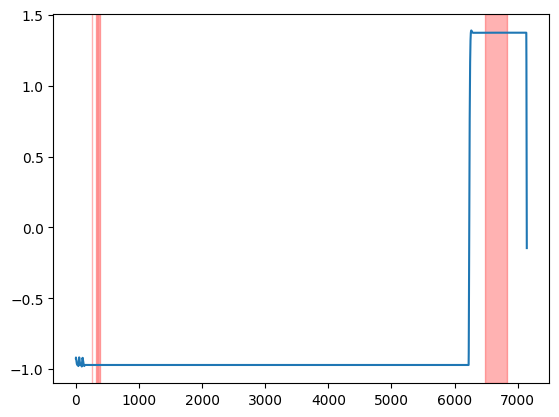

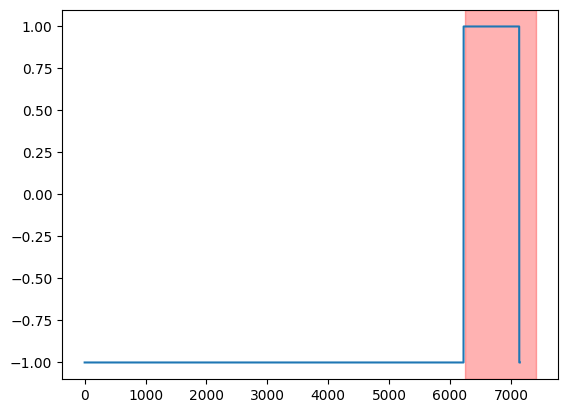

E-4
Epoch 1/35


c:\Users\Norbert\anaconda3\envs\tensorflow-cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.2502 - val_loss: 0.0957
Epoch 2/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0917 - val_loss: 0.0509
Epoch 3/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 0.0568 - val_loss: 0.0402
Epoch 4/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.0480 - val_loss: 0.0342
Epoch 5/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.0429 - val_loss: 0.0298
Epoch 6/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.0386 - val_loss: 0.0286
Epoch 7/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.0365 - val_loss: 0.0280
Epoch 8/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0356 - val_loss: 0.0279
Epoch 9/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.0314 - val_loss: 0.0277
Epoch 10/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0328 - val_loss: 0.0270
Epoch 11/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0331 - val_loss: 0.0279
Epoch 12/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.

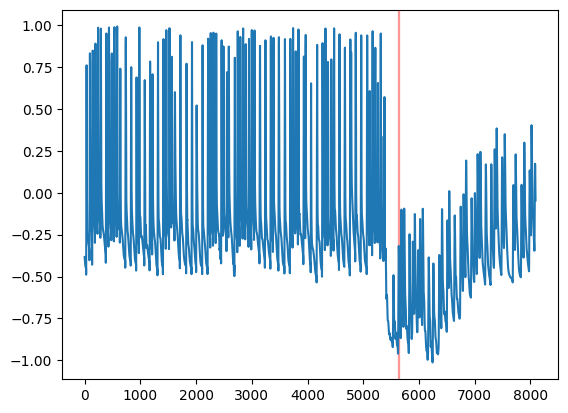

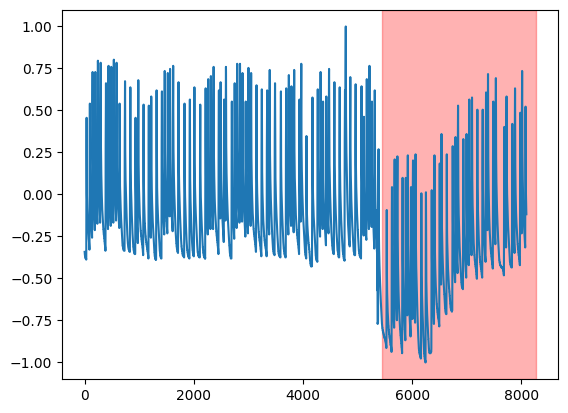

E-12
Epoch 1/35


c:\Users\Norbert\anaconda3\envs\tensorflow-cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.7668 - val_loss: 0.5022
Epoch 2/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.4800 - val_loss: 0.3729
Epoch 3/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.3690 - val_loss: 0.3321
Epoch 4/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.3311 - val_loss: 0.2975
Epoch 5/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - loss: 0.2883 - val_loss: 0.2908
Epoch 6/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 0.2953 - val_loss: 0.2779
Epoch 7/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.2876 - val_loss: 0.2667
Epoch 8/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.2827 - val_loss: 0.2649
Epoch 9/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.2706 - val_loss: 0.2585
Epoch 10/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 0.2687 - val_loss: 0.2721
Epoch 11/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.2731 - val_loss: 0.2606
Epoch 12/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.

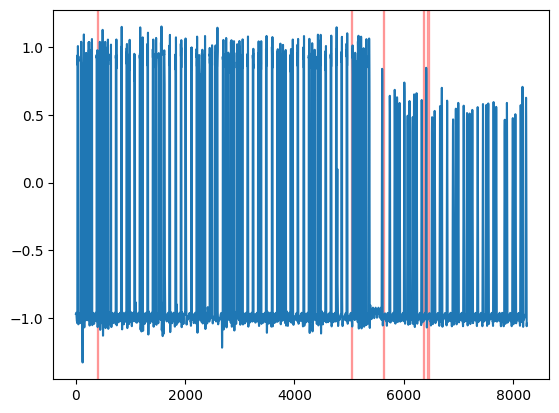

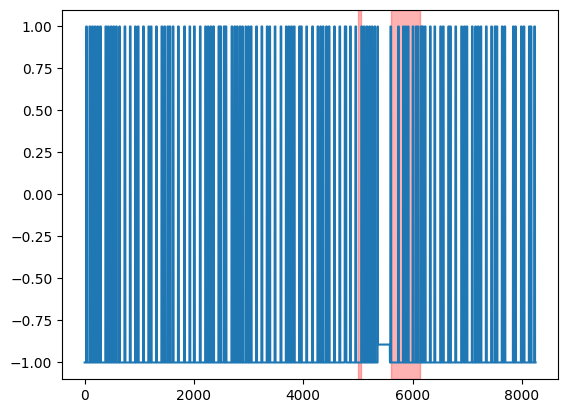

F-7
Epoch 1/35


c:\Users\Norbert\anaconda3\envs\tensorflow-cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.5784 - val_loss: 0.3836
Epoch 2/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.4091 - val_loss: 0.3783
Epoch 3/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.3929 - val_loss: 0.3803
Epoch 4/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.3839 - val_loss: 0.3703
Epoch 5/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.3937 - val_loss: 0.3676
Epoch 6/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.3823 - val_loss: 0.3506
Epoch 7/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.3600 - val_loss: 0.3422
Epoch 8/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.3487 - val_loss: 0.3368
Epoch 9/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.3471 - val_loss: 0.3280
Epoch 10/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.3404 - val_loss: 0.3204
Epoch 11/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.3273 - val_loss: 0.3178
Epoch 12/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.

In [58]:
CHANNELS = ["A-8", "D-3", "D-9", "E-4", "E-12", "F-7", "G-6", "M-3"]

for channel in CHANNELS:
    print(channel)
    new_channel = Channel(channel)
    new_channel.load_data()

    model = Model(new_channel)
    model.batch_predict(new_channel)

    errors = Errors(new_channel)
    errors.detect_anomalies()
    #max(errors.anom_scores, key=lambda x: x['score']), errors.E_seq

    plotter = Plotter(new_channel)

    plotter.plot_detected_anomalies(errors.E_seq, plot_real_data=False)
    plotter.plot_predictions(plot_real_data=True)